In [ ]:
!pip install simpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<head>
<style>
  h1 {
    font-weight: bold;
    color: darkorange;
    text-align: center;
  }
</style>
</head>

<h1>SISTEMA DE ALMACEN: USO DE LA LIBRERIA SIMPY</h1>

1° Se importan los módulos necesarios para la simulación (simpy), este bloque, la generación de números aleatorios (numpy) y la visualización de gráficos (matplotlib.pyplot).

In [ ]:
import simpy
import numpy as np
import matplotlib.pyplot as plt

2° Se declaran dos funciones auxiliares que se encargaran de generar los valores de interarribo (tiempo entre llegadas) y demanda aleatoria para el inventario.

In [ ]:
def generar_interarribo():
    return np.random.exponential(1.0 / 5) # Genera un valor de tiempo entre llegadas utilizando una distribución exponencial con media de 1/5

def generar_demanda():
    return np.random.randint(1, 5) # Genera un valor de demanda aleatoria entre 1 y 4 (ambos inclusive)

3° Se declara la función ejecutar_almacen es el proceso principal de la simulación. Se encarga de gestionar el inventario y las ventas. El bucle infinito simula el paso del tiempo, donde se generan los interarribos, se calcula el balance, se genera la demanda y se actualiza el inventario en función de las ventas. Si el inventario alcanza un punto de reorden y no hay pedidos en curso, se inicia el proceso de realizar un pedido mediante env.process(realizar_pedido(env, objetivo_pedido)).

In [ ]:
def ejecutar_almacen(env, punto_reorden, objetivo_pedido):
    global inventario, balance, num_pedidos

    inventario = objetivo_pedido                                                 # Establece el inventario inicial al objetivo de pedido
    balance = 0.0                                                                # Inicializa el balance a cero
    num_pedidos = 0.0                                                            # Inicializa el número de pedidos a cero

    while True:
        interarribo = generar_interarribo()                                      # Genera un tiempo de interarribo
        yield env.timeout(interarribo)                                           # Espera el tiempo de interarribo
        balance -= inventario * 2 * interarribo                                   # Actualiza el balance restando el costo de mantenimiento del inventario
        demanda = generar_demanda()

        if demanda < inventario:                                                 # Si la demanda es menor que el inventario disponible
            balance += 100 * demanda                                             # Incrementa el balance con el beneficio de la venta
            inventario -= demanda                                                # Actualiza el inventario restando la demanda vendida
            print('{:.2f} vendidos {}'.format(env.now, demanda))                 # Imprime el tiempo actual y la cantidad vendida
        else:
            balance += 100 * inventario                                          # Incrementa el balance con el beneficio de la venta del inventario completo
            inventario = 0                                                        # Establece el inventario a cero
            print('{:.2f} vendidos {} (sin stock)'.format(env.now, inventario))  # Imprime el tiempo actual y que no hay stock disponible

        if inventario < punto_reorden and num_pedidos == 0:
            env.process(realizar_pedido(env, objetivo_pedido))                   # Inicia el proceso de realizar un pedido

3° La función realizar_pedido representa el proceso de realizar un pedido cuando el inventario alcanza el punto de reorden. El pedido se realiza para alcanzar el objetivo de inventario. Durante el proceso de pedido, se espera un tiempo de 2 dias y luego se actualiza el inventario y se reinicia el contador de pedidos.

In [ ]:
def realizar_pedido(env, objetivo_pedido):
    global inventario, balance, num_pedidos

    num_pedidos = objetivo_pedido - inventario  # Calcula la cantidad de productos que se deben pedir para alcanzar el objetivo de pedido
    print('{:.2f} realizado pedido de {}'.format(env.now, num_pedidos))  # Imprime el tiempo actual y la cantidad de productos pedidos
    balance -= 50 * num_pedidos  # Actualiza el balance restando el costo del pedido
    yield env.timeout(2.0) # Espera un tiempo de 2 unidades (dias) para recibir el pedido
    inventario += num_pedidos # Aumenta el inventario con la cantidad de productos pedidos
    num_pedidos = 0 # Reinicia el contador de pedidos a cero
    print('{:.2f} pedido recibido, {} en inventario'.format(env.now, inventario)) # Imprime el tiempo actual y la nueva cantidad de productos en inventario

4° La función observar se utiliza para registrar y almacenar datos de observación del inventario en intervalos de tiempo regulares. En cada iteración del bucle, se registra el tiempo actual (env.now) y el nivel actual del inventario. Luego se espera un tiempo de 0.1 unidades antes de la siguiente observación.

In [ ]:
def observar(env):
    global inventario

    while True: # Bucle infinito para observar continuamente el inventario
        tiempo_observado.append(env.now) # Agrega el tiempo actual a la lista de tiempos observados
        nivel_inventario.append(inventario) # Agrega el nivel actual del inventario a la lista de niveles de inventario
        yield env.timeout(0.1) # Espera un tiempo de 0.1 unidades antes de la siguiente observación

5° En el bloque principal, se establece la semilla para la generación de números aleatorios y se inicializan las listas tiempo_observado y nivel_inventario para almacenar los datos observados. Luego, se crea el entorno de simulación (simpy.Environment()) y se inician los procesos ejecutar_almacen y observar. Finalmente, se ejecuta la simulación hasta un tiempo de simulación de 5 unidades.

In [ ]:
np.random.seed(0) # Establece la semilla para la generación de números aleatorios para reproducibilidad

tiempo_observado = [] # Lista para almacenar los tiempos observados
nivel_inventario = [] # Lista para almacenar los niveles de inventario observados

env = simpy.Environment() # Crea el entorno de simulación
env.process(ejecutar_almacen(env, 20, 50)) # Inicia el proceso de ejecutar el almacén con parámetros de punto de reorden y objetivo de pedido
env.process(observar(env)) # Inicia el proceso de observación del inventario

env.run(until=5.0) # Ejecuta la simulación hasta alcanzar un tiempo de 5.0 unidades

0.16 vendidos 2
0.53 vendidos 4
0.69 vendidos 2
0.88 vendidos 3
1.00 vendidos 3
1.01 vendidos 1
1.11 vendidos 3
1.44 vendidos 3
1.61 vendidos 2
1.97 vendidos 1
1.99 vendidos 4
2.08 vendidos 2
2.38 vendidos 4
2.38 realizado pedido de 34
2.79 vendidos 4
3.11 vendidos 4
3.26 vendidos 4
3.28 vendidos 1
3.46 vendidos 2
4.04 vendidos 0 (sin stock)
4.06 vendidos 0 (sin stock)
4.12 vendidos 0 (sin stock)
4.38 pedido recibido, 34 en inventario
4.39 vendidos 1
4.56 vendidos 1
4.63 vendidos 2
4.82 vendidos 1
4.92 vendidos 1


6° Se utiliza la función de matplotlib.pyplot para dibujar un gráfico escalonado a partir de los datos de observación y se agregan etiquetas a los ejes. Finalmente, se muestra el gráfico en pantalla utilizando plt.show().

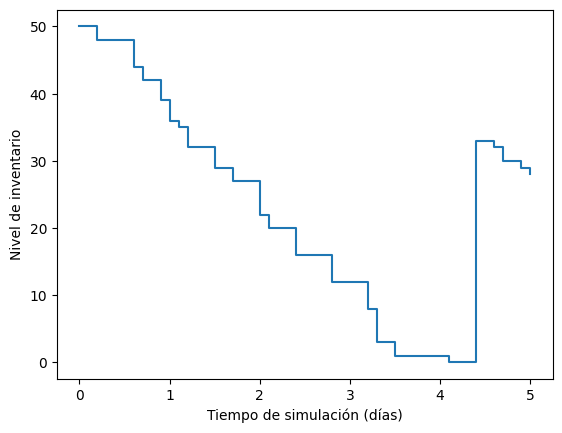

In [ ]:
plt.figure()
plt.step(tiempo_observado, nivel_inventario, where='post') # Dibuja un gráfico escalonado utilizando los tiempos observados como valores x y los niveles de inventario observados como valores y
plt.xlabel("Tiempo de simulación (días)")
plt.ylabel("Nivel de inventario")
plt.show()